cifar10 (https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. Here follow the ten object classes:
* airplane
*	automobile
*	bird
*	cat
*	deer
*	dog
*	frog
*	horse
*	ship
*	truck

Here follows some data samples in the dataset:

![alt text](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import keras              # Keras is the high-level API of TensorFlow

In [2]:
# Load the cifar10 dataset and split train/test
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("Train shape: X_train = " + str(X_train.shape) + ", y_train = " + str(y_train.shape))
print("Test shape: X_test = " + str(X_test.shape) + ", y_test = " + str(y_test.shape))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Train shape: X_train = (50000, 32, 32, 3), y_train = (50000, 1)
Test shape: X_test = (10000, 32, 32, 3), y_test = (10000, 1)


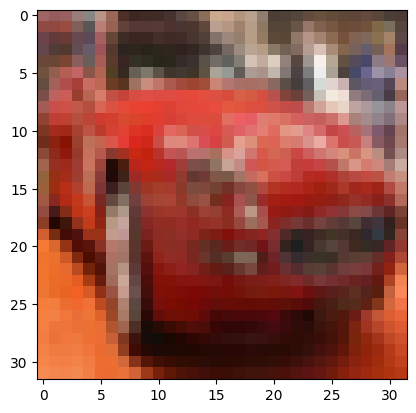

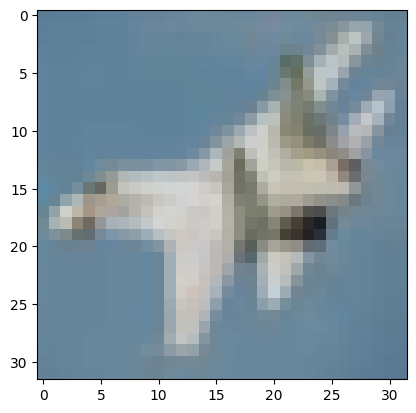

In [3]:
# Show some samples in the dataset
import matplotlib.pyplot as plt
imgplot = plt.imshow(X_train[5])
plt.show()
imgplot = plt.imshow(X_test[10])
plt.show()

In [4]:
# Normalize pixel values
X_train, X_test = X_train/255.0, X_test/255.0

In [5]:
# Split train/valid from the training set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=5)

print("Train shape: X_train = " + str(X_train.shape) + ", y_train = " + str(y_train.shape))
print("Val shape: X_val = " + str(X_val.shape) + ", y_val = " + str(y_val.shape))
print("Test shape: X_test = " + str(X_test.shape) + ", y_test = " + str(y_test.shape))

Train shape: X_train = (45000, 32, 32, 3), y_train = (45000, 1)
Val shape: X_val = (5000, 32, 32, 3), y_val = (5000, 1)
Test shape: X_test = (10000, 32, 32, 3), y_test = (10000, 1)


# Build 93% model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Function to create a convolutional block with optional MaxPooling and Dropout
def conv_block(in_channels, out_channels, pool=False, dropout_rate=0.3):
    block = models.Sequential()
    block.add(layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', input_shape=(None, None, in_channels)))
    block.add(layers.BatchNormalization(epsilon=1e-05, momentum=0.1))  # BatchNorm2D equivalent
    block.add(layers.ReLU())
    if pool:
        block.add(layers.MaxPooling2D(pool_size=2, strides=2))
    # Add Dropout layer after each convolutional block
    block.add(layers.Dropout(dropout_rate))
    return block

# Function to create a residual block with two convolutional layers and Dropout
def res_block(channels, dropout_rate=0.3):
    block = models.Sequential([
        models.Sequential([
            layers.Conv2D(channels, kernel_size=3, padding='same'),
            layers.BatchNormalization(epsilon=1e-05, momentum=0.1),  # BatchNorm2D equivalent
            layers.ReLU(),
            layers.Dropout(dropout_rate)  # Add Dropout after the first conv
        ]),
        models.Sequential([
            layers.Conv2D(channels, kernel_size=3, padding='same'),
            layers.BatchNormalization(epsilon=1e-05, momentum=0.1),  # BatchNorm2D equivalent
            layers.ReLU(),
            layers.Dropout(dropout_rate)  # Add Dropout after the second conv
        ])
    ])
    return block

# Function to create the ResNet9 model with Dropout and adjusted BatchNorm
def create_model(in_channels, num_classes, dropout_rate=0.3):
    inputs = layers.Input(shape=(32, 32, in_channels))  # Assuming input shape is 32x32 images with 3 channels (RGB)

    # conv1 block
    x = conv_block(in_channels, 64, dropout_rate=0.2)(inputs)

    # conv2 block
    x = conv_block(64, 128, pool=True, dropout_rate=dropout_rate)(x)

    # res1 block
    res1 = res_block(128, dropout_rate=dropout_rate)(x)
    x = layers.Add()([x, res1])  # Add skip connection

    # conv3 block
    x = conv_block(128, 256, pool=True, dropout_rate=dropout_rate)(x)

    # conv4 block
    x = conv_block(256, 350, pool=True, dropout_rate=dropout_rate)(x)

    # res2 block
    res2 = res_block(350, dropout_rate=dropout_rate)(x)
    x = layers.Add()([x, res2])  # Add skip connection

    # Classifier block
    x = layers.MaxPooling2D(pool_size=4)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes)(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate the model
model = create_model(in_channels=3, num_classes=10, dropout_rate=0.3)

# Build the model by calling it on a dummy input
dummy_input = tf.random.normal([1, 32, 32, 3])  # Assuming input size is 32x32 RGB images
_ = model(dummy_input)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 32, 32, 64)     │          2,048 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 16, 16, 128)    │         74,368 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 16, 16, 128)    │        296,192 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 128)    │              0 │ sequential_1[0][0],    │
│                           │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 8, 8, 256)      │        296,192 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 4, 4, 350)      │        808,150 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 4, 4, 350)      │      2,208,500 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 4, 4, 350)      │              0 │ sequential_6[0][0],    │
│                           │                        │                │ sequential_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 1, 1, 350)      │              0 │ add_1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 1, 1, 350)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 350)            │              0 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10)             │          3,510 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,688,960 (14.07 MB)

 Trainable params: 3,685,452 (14.06 MB)

 Non-trainable params: 3,508 (13.70 KB)

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Train

In [8]:
# model.load_weights('/kaggle/input/model-93-h5/model_0.9341999888420105.h5')

## Train preweight

In [9]:
import tensorflow as tf
import keras              # Keras is the high-level API of TensorFlow
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
# Train the model. Using Colab for training
history = model.fit(X_train, y_train, # Data feature and data label
                    batch_size=256, # Batch size
                    epochs=30, # Number of training epochs
                    validation_data=(X_val, y_val), # Validation set
                    callbacks=[early_stop]) # Use callback ModelCheckpoint during the training

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 235ms/step - accuracy: 0.1737 - loss: 4.6792 - val_accuracy: 0.2582 - val_loss: 1.9794
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.3241 - loss: 2.2443 - val_accuracy: 0.4590 - val_loss: 1.5979
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.4364 - loss: 1.8103 - val_accuracy: 0.5246 - val_loss: 1.4165
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.5073 - loss: 1.5927 - val_accuracy: 0.5690 - val_loss: 1.2130
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.5647 - loss: 1.3961 - val_accuracy: 0.5988 - val_loss: 1.1572
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.6137 - loss: 1.2231 - val_accuracy: 0.6644 - val_loss: 1.0262
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.6396 - loss: 1.1160 - val_accuracy: 0.6548 - val_loss: 0.9721
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.6712 - loss: 1

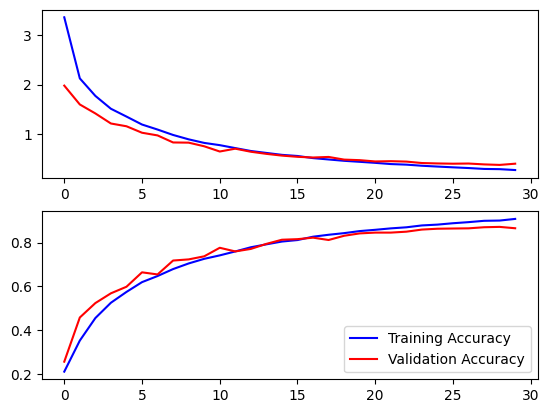

In [10]:
# Visualize training and validation performance
f,ax=plt.subplots(2,1)

# Plot training and validation loss
ax[0].plot(history.history['loss'], color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

## Train with image augmentation to 92%

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
datagen.fit(X_train)

In [19]:
import tensorflow as tf
import keras              # Keras is the high-level API of TensorFlow
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping

# Custom callback to stop training when accuracy reaches 0.95
class StopAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy*100}% accuracy, stopping training!")
            self.model.stop_training = True

# Create the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)

# Create the StopAtAccuracy callback with a target of 0.93 accuracy
stop_at_acc = StopAtAccuracy(target_accuracy=0.932)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                    epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, stop_at_acc])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.9103 - loss: 0.2816 - val_accuracy: 0.9268 - val_loss: 0.2261
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.9206 - loss: 0.2268 - val_accuracy: 0.9286 - val_loss: 0.2166
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 53s 146ms/step - accuracy: 0.9227 - loss: 0.2177 - val_accuracy: 0.9242 - val_loss: 0.2299
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.9266 - loss: 0.2075 - val_accuracy: 0.9254 - val_loss: 0.2265
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9268 - loss: 0.2119 - val_accuracy: 0.9248 - val_loss: 0.2304
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.9275 - loss: 0.2102 - val_accuracy: 0.9228 - val_loss: 0.2377
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9299 - loss: 0.2043 - val_accuracy: 0.9272 - val_loss: 0.2229
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9296 - loss: 0.2020 - val

## Combine aug and normal image to 93.6

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# ImageDataGenerator for augmenting the 20% of the data
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

rate = 0.8

# Define a generator to yield the combined normal and augmented data per epoch
def mixed_data_generator(X_train_normal, y_train_normal, X_train_aug, y_train_aug, datagen, batch_size):
    # Number of batches for 70% normal and 30% augmented samples
    normal_batches = int(batch_size * rate)
    aug_batches = batch_size - normal_batches

    num_normal_samples = len(X_train_normal)
    num_aug_samples = len(X_train_aug)

    # Infinite generator loop
    while True:
        # Shuffle indices instead of entire datasets
        idx_normal = np.random.permutation(num_normal_samples)

        # Loop over the normal data in chunks (without shuffling the entire dataset at once)
        for i in range(0, num_normal_samples, normal_batches):
            # Create smaller, shuffled batches on the fly
            batch_indices = idx_normal[i:i + normal_batches]
            normal_X_batch = X_train_normal[batch_indices]
            normal_y_batch = y_train_normal[batch_indices]

            # Generate augmented data only for the current batch
            aug_X_batch, aug_y_batch = next(datagen.flow(X_train_aug, y_train_aug, batch_size=aug_batches))

            # Combine the batches
            combined_X_batch = np.concatenate([normal_X_batch, aug_X_batch], axis=0)
            combined_y_batch = np.concatenate([normal_y_batch, aug_y_batch], axis=0)

            # Yield the combined batch
            yield combined_X_batch, combined_y_batch


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Set batch size
batch_size = 256

# Mixed data generator
train_generator = mixed_data_generator(X_train, y_train, X_train, y_train, datagen, batch_size)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // int(batch_size * rate),  # Steps for 80% normal and 20% augmented data
    epochs=80,
    validation_data=(X_val, y_val),  # Validation set
    callbacks=[early_stop]
)


Epoch 1/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.9708 - loss: 0.0875 - val_accuracy: 0.9342 - val_loss: 0.1958
Epoch 2/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.9761 - loss: 0.0725 - val_accuracy: 0.9390 - val_loss: 0.1984
Epoch 3/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.9767 - loss: 0.0689 - val_accuracy: 0.9402 - val_loss: 0.2004
Epoch 4/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.9764 - loss: 0.0690 - val_accuracy: 0.9392 - val_loss: 0.1978
Epoch 5/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9777 - loss: 0.0679 - val_accuracy: 0.9362 - val_loss: 0.2124
Epoch 6/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9778 - loss: 0.0662 - val_accuracy: 0.9364 - val_loss: 0.2009
Epoch 7/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9774 - loss: 0.0675 - val_accuracy: 0.9376 - val_loss: 0.1987
Epoch 8/80
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.9768 - loss: 0

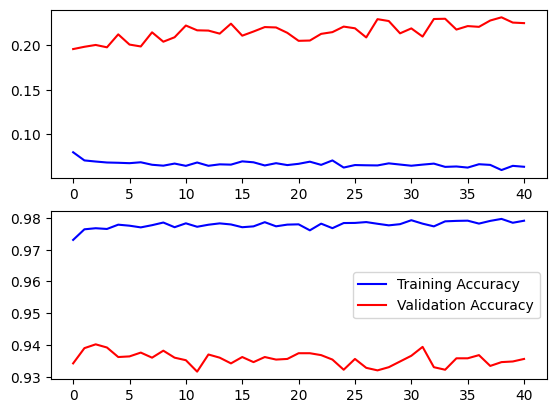

In [21]:
# Visualize training and validation performance
f,ax=plt.subplots(2,1)

# Plot training and validation loss
ax[0].plot(history.history['loss'], color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

# Plot training and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [22]:
# Let us load a saved model and evaluate its performance on the test set
result = model.evaluate(X_test, y_test) # If unspecified, batch_size will default to 32

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9336 - loss: 0.2076


In [23]:
# Show the model performance
print(model.metrics_names) # result[0] is loss, result[1] is accuracy. The metrics are defined in AlexNet.complie(...)
print("Loss and accuracy on the test set: loss = {}, accuracy = {}".format(result[0],result[1]))

['loss', 'compile_metrics']
Loss and accuracy on the test set: loss = 0.20507633686065674, accuracy = 0.9343000054359436
